In [47]:
#Ryan Shin: sungjin7127@gmail.com
#Date: 160927
#Obj: find the best model for emotion recogntion

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#%matplotlib inline
print ("Packages loaded")

#Load data
cwd = os.getcwd()
loadpath = cwd + "/dataset/data_gray.npz"
l = np.load(loadpath)

#Check what's included
print (l.files)

# Parse data
trainimg = l['trainimg']
trainlabel = l['trainlabel']
testimg = l['testimg']
testlabel = l['testlabel']
imgsize = l['imgsize']
#use_gray = l['use_gray']
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d train images loaded" % (ntrain))
print ("%d test images loaded" % (ntest))
print ("%d dimensional input" % (dim))
print ("Image size is %s" % (imgsize))
print ("%d classes" % (nclass))

Packages loaded
['trainlabel', 'trainimg', 'imgsize', 'testimg', 'testlabel']
2614 train images loaded
1743 test images loaded
784 dimensional input
Image size is [28 28]
8 classes


In [76]:
a = trainimg[0]
a2 = a.reshape(28,28)
a2.shape

(28, 28)

<function matplotlib.pyplot.show>

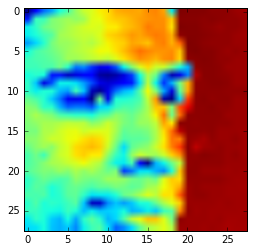

In [77]:
%matplotlib inline
plt.imshow(a2)
plt.show

In [48]:
device_type = "/cpu:0"

In [53]:
with tf.device(device_type): # <= This is optional
    n_input  = 784
    n_output = 8
    weights  = {
        'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1)),
        'wd1': tf.Variable(tf.random_normal([14*14*64, n_output], stddev=0.1))
    }
    biases   = {
        'bc1': tf.Variable(tf.random_normal([64], stddev=0.1)),
        'bd1': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    def conv_simple(_input, _w, _b):
        # Reshape input
        _input_r = tf.reshape(_input, shape=[-1, 28, 28, 1])
        # Convolution
        _conv1 = tf.nn.conv2d(_input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
        # Add-bias
        _conv2 = tf.nn.bias_add(_conv1, _b['bc1'])
        # Pass ReLu
        _conv3 = tf.nn.relu(_conv2)
        # Max-pooling
        _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        # Vectorize
        _dense = tf.reshape(_pool, [-1, _w['wd1'].get_shape().as_list()[0]])
        # Fully-connected layer
        _out = tf.add(tf.matmul(_dense, _w['wd1']), _b['bd1'])
        # Return everything
        out = {
            'input_r': _input_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
            , 'pool': _pool, 'dense': _dense, 'out': _out
        }
        return out
print ("CNN ready")

CNN ready


In [54]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
#keepratio = tf.placeholder(tf.float32)

# Parameters
learning_rate   = 0.001
training_epochs = 10
batch_size      = 100
display_step    = 1
# Functions! 
with tf.device(device_type): # <= This is optional
    _pred = conv_simple(x, weights, biases)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(_pred, y))
    optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    _corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
    accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
    init = tf.initialize_all_variables()
# Saver 
save_step = 1;
savedir = "./nets"
if not os.path.exists(savedir):
    os.makedirs(savedir)

saver = tf.train.Saver(max_to_keep=3) 
print ("Network Ready to Go!")

Network Ready to Go!


In [55]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [56]:
if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(ntrain/batch_size)+1
        #total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            randidx = np.random.randint(ntrain, size=batch_size)
            batch_xs = trainimg[randidx, :]
            batch_ys = trainlabel[randidx, :]
            #batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel})
            print (" Test accuracy: %.3f" % (test_acc))

        # Save Net
        if epoch % save_step == 0:
            saver.save(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("Optimization Finished.")

Epoch: 000/010 cost: 2.027875357
 Training accuracy: 0.210
 Test accuracy: 0.193
Epoch: 001/010 cost: 1.851472060
 Training accuracy: 0.300
 Test accuracy: 0.338
Epoch: 002/010 cost: 1.744806767
 Training accuracy: 0.420
 Test accuracy: 0.374
Epoch: 003/010 cost: 1.630655055
 Training accuracy: 0.520
 Test accuracy: 0.370
Epoch: 004/010 cost: 1.505236573
 Training accuracy: 0.540
 Test accuracy: 0.499
Epoch: 005/010 cost: 1.399978267
 Training accuracy: 0.590
 Test accuracy: 0.497
Epoch: 006/010 cost: 1.305694664
 Training accuracy: 0.650
 Test accuracy: 0.549
Epoch: 007/010 cost: 1.223827296
 Training accuracy: 0.670
 Test accuracy: 0.550
Epoch: 008/010 cost: 1.164499685
 Training accuracy: 0.620
 Test accuracy: 0.581
Epoch: 009/010 cost: 1.069211737
 Training accuracy: 0.720
 Test accuracy: 0.571
Optimization Finished.
